In [2]:
import numpy as np
from dipy.viz import regtools
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                    AffineMap,
                                    MutualInformationMetric,
                                    AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                        RigidTransform3D,
                                        AffineTransform3D)
import matplotlib.pyplot as plt
import dipy.align.metrics as metrics

In [2]:
ref_data, ref_affine, ref_im = load_nifti("../images/skull_stripped/tac_0d_Tilt_1_skullstripped.nii.gz", return_img=True)
ref_grid2world = ref_affine

moving_data, moving_affine, moving_im = load_nifti("../images/skull_stripped/tac_1w_Tilt_1_skullstripped.nii.gz", return_img=True)
moving_grid2world = moving_affine

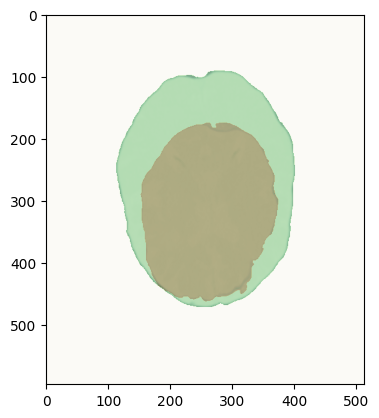

In [3]:
"""
Resample the moving data grid to the reference data grid using an affine transformation.
"""
I = np.eye(4)
affine_map = AffineMap(I,
                       ref_data.shape, ref_grid2world,
                       moving_data.shape, moving_grid2world)

resampled_data = affine_map.transform(moving_data)

plt.imshow(ref_data[:, :, ref_data.shape[-1]//2].T, cmap='Reds', alpha=0.5)
plt.imshow(moving_data[:, :, moving_data.shape[-1]//2].T, cmap='Greens', alpha=0.5)


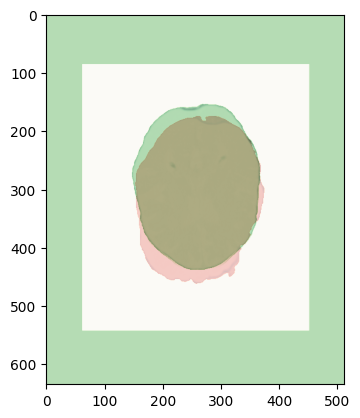

In [59]:
"""
Get a very rough estimate of registration by just aligning the centers of mass of the two images.
"""
c_of_mass = transform_centers_of_mass(ref_data, ref_grid2world,
                                      moving_data, moving_grid2world)

transformed = c_of_mass.transform(moving_data)

plt.imshow(ref_data[:, :, ref_data.shape[-1]//2].T, cmap='Reds', alpha=0.5)
plt.imshow(transformed[:, :, transformed.shape[-1]//2].T, cmap='Greens', alpha=0.5)


In [60]:
# Define an affine registration object
metric = MutualInformationMetric(nbins=32, sampling_proportion=None)
iters_pyramid = [1000, 100, 10]
affine_reg = AffineRegistration(metric=metric, level_iters=iters_pyramid,
                                sigmas=[3.0, 1.0, 0.0], factors=[4, 2, 1])



In [61]:
# Now perform registration in several stages.
# The translation stage
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affine_reg.optimize(ref_data, moving_data, transform, params0,
                                  ref_grid2world, moving_grid2world,
                                  starting_affine=starting_affine)
# Apply the translation registration
transformed = translation.transform(moving_data)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]


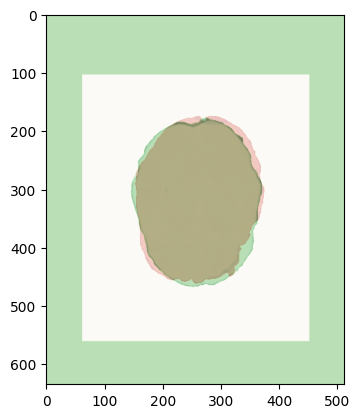

In [62]:
# Visualize the result of the rigid registration.
plt.imshow(ref_data[:, :, ref_data.shape[-1]//2].T, cmap='Reds', alpha=0.5)
plt.imshow(transformed[:, :, transformed.shape[-1]//2].T, cmap='Greens', alpha=0.5)

In [63]:
# Now perform registration in several stages.
# The affine stage
transform = AffineTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affine_reg.optimize(ref_data, moving_data, transform, params0,
                                  ref_grid2world, moving_grid2world,
                                  starting_affine=starting_affine)
# Apply the translation registration
transformed = translation.transform(moving_data)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]


KeyboardInterrupt: 

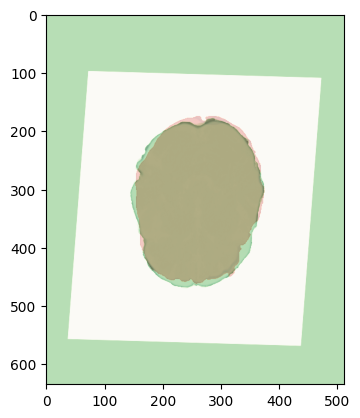

In [ ]:
# Visualize the result of the rigid registration.
plt.imshow(ref_data[:, :, ref_data.shape[-1]//2].T, cmap='Reds', alpha=0.5)
plt.imshow(transformed[:, :, transformed.shape[-1]//2].T, cmap='Greens', alpha=0.5)

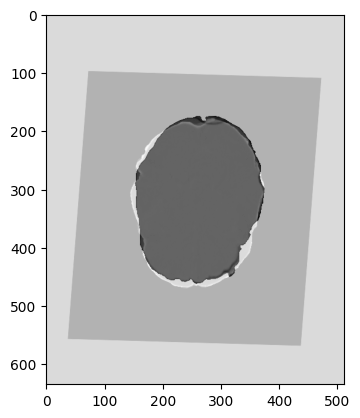

In [ ]:
diff_im = transformed - ref_data
plt.imshow(diff_im[:, :, diff_im.shape[-1]//2].T, cmap='gray', alpha=1)


## 1) FSL Registered images

## 

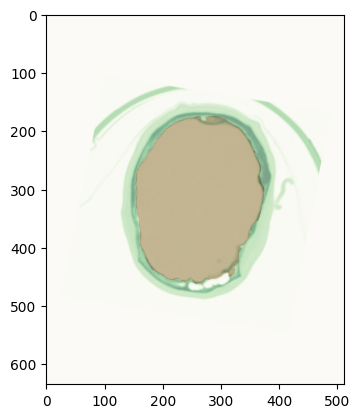

In [4]:
fsl_data, fsl_grid2world, fsl_im = load_nifti("../images/fsl/rigid_tac_1w_Tilt_1_moved_to_day_0.nii.gz", return_img=True)
ref_data, ref_grid2world, ref_im = load_nifti("../images/skull_stripped/tac_0d_Tilt_1_skullstripped.nii.gz", return_img=True)
I = np.eye(4)
affine_map = AffineMap(I,
                       fsl_data.shape, fsl_grid2world,
                        ref_data.shape, ref_grid2world)
resampled_fsl = affine_map.transform(fsl_data)


plt.imshow(ref_data[:, :, ref_data.shape[-1]//2].T, cmap='Reds', alpha=0.5)
plt.imshow(resampled_fsl[:, :, resampled_fsl.shape[-1]//2].T, cmap='Greens', alpha=0.5)

#### Load Strip skull of tac_0d_Tilt_1.nii.gz

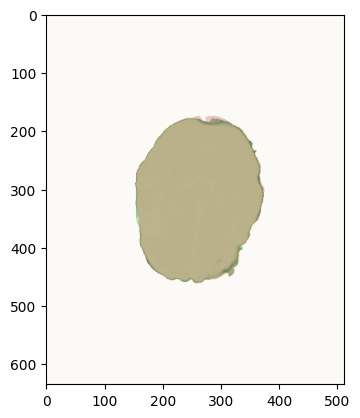

In [5]:
stripped_data, stripped_grid2world, stripped_im = load_nifti("../images/skull_stripped/rigid_tac_1w_Tilt_1_moved_to_day_0_skst.nii.gz", return_img=True)

plt.imshow(ref_data[:, :, ref_data.shape[-1]//2].T, cmap='Reds', alpha=0.5)
plt.imshow(stripped_data[:, :, stripped_data.shape[-1]//2].T, cmap='Greens', alpha=0.5)

In [14]:
norm_stripped = (stripped_data - np.min(stripped_data)) / np.max((stripped_data - np.min(stripped_data)))
norm_ref = (ref_data - np.min(ref_data)) / np.max((ref_data - np.min(ref_data)))
diff_im_substract = -(norm_stripped - norm_ref)
diff_im_multiply = norm_stripped * norm_ref

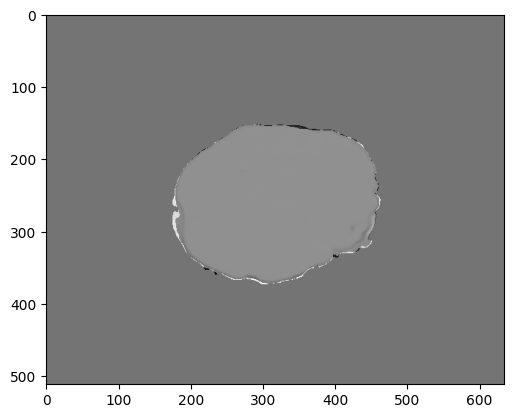

In [15]:
plt.imshow(diff_im_substract[:, :, diff_im_substract.shape[-1]//2], cmap="gray")

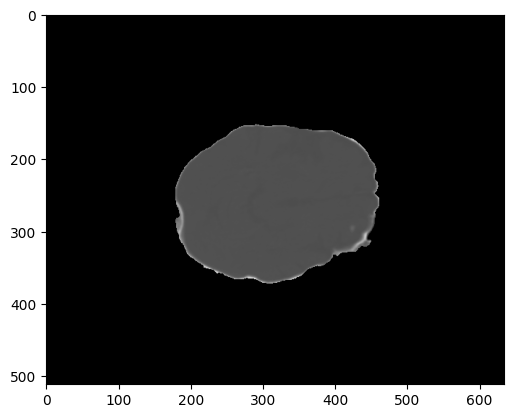

In [16]:
plt.imshow(diff_im_multiply[:, :, diff_im_multiply.shape[-1]//2], cmap="gray")

In [17]:
from dipy.io.image import save_nifti
save_nifti("../images/DiffImSubstract.nii.gz", diff_im_substract, ref_grid2world)
save_nifti("../images/DiffImMulitply.nii.gz", diff_im_multiply, ref_grid2world)